In [24]:
import os
import gc
import time
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [25]:
root_folder='.'
train_filename='hind.txt'
DATA_PATH = os.path.abspath(os.path.join(root_folder))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
train_path = DATA_PATH
test_path = DATA_PATH

In [26]:
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 20000 
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024 
BATCH_SIZE = 8 
EPOCHS = 20  
ATTENTION_FUNC='general'

In [27]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip()

    return w

In [28]:
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[INPUT_COLUMN,TARGET_COLUMN], usecols=[0,1], nrows=NUM_SAMPLES)
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[15])
print(target_data[15])
print(target_input_data[15])

awesome !
बहत बढिया ! <eos>
<sos> बहत बढिया !


In [29]:
df

,input,target
0,Wow!,वाह!
1,Duck!,झुको!
2,Duck!,बतख़!
3,Help!,बचाओ!
4,Jump.,उछलो.
...,...,...
2944,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2945,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2946,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2947,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...


In [30]:
dummy=['I am Raj .']
t=Tokenizer()
t.fit_on_texts(dummy)
t.texts_to_sequences(dummy)

[[1, 2, 3]]

In [31]:
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
input_max_len = max(len(s) for s in input_sequences)

print('Max Input Length: ', input_max_len)
print(input_data[15])
print(input_sequences[15])

Max Input Length:  25
awesome !
[1305, 60]


In [32]:
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)
target_max_len = max(len(s) for s in target_sequences)

print('Max Target Length: ', target_max_len)
print(target_data[15])
print(target_sequences[15])
print(target_input_data[15])
print(target_sequences_inputs[15])

Max Target Length:  28
बहत बढिया ! <eos>
[16, 1454, 70, 1]
<sos> बहत बढिया !
[2, 16, 1454, 70]


In [33]:
word2idx_inputs = tokenizer_inputs.word_index
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

print('Found %s unique input tokens.' % len(word2idx_inputs))
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 2444 unique input tokens.
Found 2823 unique output tokens.


In [34]:
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (2949, 25)
encoder_inputs[0]: [1303   60    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs[0]: [   2 1443   70    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (2949, 28)


In [35]:
len(input_data)==len(target_data)==len(target_input_data)

True

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((encoder_inputs, decoder_inputs, decoder_targets))
for element in dataset:
  print(element)
  print(len(element))
  print(type(element[0]))
  print(type(element[1]))
  print(type(element[2]))
  break

(<tf.Tensor: shape=(25,), dtype=int32, numpy=
array([1303,   60,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>, <tf.Tensor: shape=(28,), dtype=int32, numpy=
array([   2, 1443,   70,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>, <tf.Tensor: shape=(28,), dtype=int32, numpy=
array([1443,   70,    1,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>)
3
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [37]:
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)

In [38]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm=tf.keras.layers.LSTM(hidden_dim,return_sequences=True,return_state=True)

  def call(self,input_sequence,states):
    embed=self.embedding(input_sequence) 
    output, state_h, state_c = self.lstm(embed, initial_state=states)
    return output, state_h, state_c

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.hidden_dim]),tf.zeros([batch_size, self.hidden_dim]))

In [39]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,hidden_dim):
    super(Decoder,self).__init__()
    self.hidden_dim=hidden_dim
    self.embedding=tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.lstm=tf.keras.layers.LSTM(hidden_dim,return_sequences=True,return_state=True)
    self.dense=tf.keras.layers.Dense(vocab_size)

  def call(self,input_sequence,state_tuple):
    embed=self.embedding(input_sequence)
    lstm_out,state_h,state_c=self.lstm(embed, initial_state=state_tuple)
    logits=self.dense(lstm_out)
    return logits, state_h, state_c

In [40]:
print("Embedding dimension "+str(EMBEDDING_DIM))
print("Hidden dimension "+str(HIDDEN_DIM))
print("Batch Size "+str(BATCH_SIZE))

Embedding dimension 128
Hidden dimension 1024
Batch Size 8


In [41]:
num_words_inputs = len(word2idx_inputs) + 1
num_words_outputs = len(word2idx_outputs) + 1

encoder=Encoder(num_words_inputs,EMBEDDING_DIM,HIDDEN_DIM)

initial_states = encoder.init_states(1)

test_encoder_output = encoder(tf.constant([[1, 23, 4, 5, 0, 0]]), initial_states) 

decoder=Decoder(num_words_outputs,EMBEDDING_DIM,HIDDEN_DIM)

de_initial_state = test_encoder_output[1:]

test_decoder_output= decoder(tf.constant([[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)

test_decoder_output

(<tf.Tensor: shape=(1, 8, 2824), dtype=float32, numpy=
 array([[[ 9.2315080e-05,  8.2776317e-04, -1.5103396e-03, ...,
           3.4174835e-04, -4.4967886e-03, -4.2192920e-04],
         [ 1.2263848e-03, -9.7028259e-04, -1.0620474e-03, ...,
          -8.7562250e-05, -2.9944144e-03, -1.5900625e-03],
         [ 1.6452132e-03, -2.1186019e-03, -8.1597478e-04, ...,
           1.6904059e-03, -1.3592783e-03, -2.7263323e-03],
         ...,
         [ 1.4884277e-03,  2.2038845e-03, -4.2629568e-03, ...,
           1.9867714e-03,  4.3509359e-04, -7.2634076e-03],
         [ 5.0800183e-04,  4.1320738e-03, -5.0357073e-03, ...,
           2.9886062e-03,  1.0172580e-03, -9.4689541e-03],
         [-2.9061362e-04,  5.7774219e-03, -5.6430628e-03, ...,
           3.9409446e-03,  1.3738361e-03, -1.1137882e-02]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
 array([[ 0.00317925, -0.00346166,  0.00850463, ..., -0.00272204,
         -0.00107026, -0.00230592]], dtype=float32)>,
 <tf.Ten

In [42]:
def loss_func(targets,logits):
  crossentropy=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64) #Convert boolean to int
  loss = crossentropy(targets, logits, sample_weight=mask)
  return loss

def accuracy_fn(y_true, y_pred):
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32') 
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')


    mask = K.cast(K.greater(y_true, 0), dtype='float32') 
    n_correct = K.sum(mask * correct) 
    n_total = K.sum(mask) 

    return n_correct / n_total


In [43]:
@tf.function

def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        de_states = en_outputs[1:]
        de_outputs = decoder(target_seq_in, de_states)
        logits = de_outputs[0]
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

In [44]:
dataset.take(-1)

<TakeDataset shapes: ((8, 25), (8, 28), (8, 28)), types: (tf.int32, tf.int32, tf.int32)>

In [45]:
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    losses = []
    accuracies = []

    for e in range(n_epochs):
        start = time.time()
        en_initial_states = encoder.init_states(batch_size)
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [46]:
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
checkpoint_dir = './training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 2.1993 Acc:0.0000
Epoch 1 Batch 100 Loss 2.1483 Acc:0.1519
Epoch 1 Batch 200 Loss 1.4734 Acc:0.1379
Epoch 1 Batch 300 Loss 1.3007 Acc:0.1667
Time taken for 1 epoch 53.4832 sec

Epoch 2 Batch 0 Loss 1.2978 Acc:0.2222
Epoch 2 Batch 100 Loss 1.2065 Acc:0.2264
Epoch 2 Batch 200 Loss 1.1391 Acc:0.2456
Epoch 2 Batch 300 Loss 1.6162 Acc:0.2297
Time taken for 1 epoch 51.6168 sec

Epoch 3 Batch 0 Loss 1.3839 Acc:0.2361
Epoch 3 Batch 100 Loss 1.2399 Acc:0.2639
Epoch 3 Batch 200 Loss 1.1314 Acc:0.2500
Epoch 3 Batch 300 Loss 1.1556 Acc:0.3175
Time taken for 1 epoch 49.9654 sec

Epoch 4 Batch 0 Loss 0.8904 Acc:0.3750
Epoch 4 Batch 100 Loss 1.0086 Acc:0.3115
Epoch 4 Batch 200 Loss 1.0696 Acc:0.3016
Epoch 4 Batch 300 Loss 1.0648 Acc:0.2545
Time taken for 1 epoch 51.7049 sec

Epoch 5 Batch 0 Loss 1.0596 Acc:0.2941
Epoch 5 Batch 100 Loss 0.8958 Acc:0.3750
Epoch 5 Batch 200 Loss 1.3016 Acc:0.2785
Epoch 5 Batch 300 Loss 1.0973 Acc:0.2769
Time taken for 1 epoch 49.8239 sec

Epoch 6 Ba

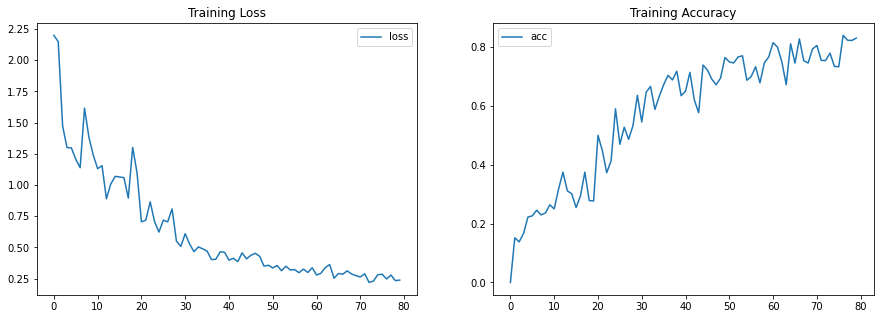

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()